In [2]:
from UDR.udr import train_test_ppo_with_udr
from PPO.ppo_test import train_and_test_policy

n_episodes = 20000
mean_timestep = 300
target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"
base_output_folder = "./udr_output"

# optimized for PPO without UDR in source environment
optimized_clip_range = 0.19877024509129543
optimized_learning_rate = 0.0008
optimized_gamma = 0.992

print("*** PPO without UDR ***")
train_and_test_policy(
    train_env=source_env,
    test_env=target_env,
    output_folder=f"./{base_output_folder}/no-udr/",
    clip_range=optimized_clip_range,
    learning_rate=optimized_learning_rate,
    gamma=optimized_gamma,
    episodes=n_episodes,
    timesteps=mean_timestep,
    print_std_deviation=True
)

deltas = [0.2, 0.5, 0.8]
for delta in deltas:
    print(f"\n*** PPO with UDR delta: {delta} ***")
    output_folder = f"{base_output_folder}/{delta}"

    train_test_ppo_with_udr(
		output_folder=output_folder,
		train_env=source_env,
		test_env=target_env,
		episodes=n_episodes,
		clip_range=optimized_clip_range,
        learning_rate=optimized_learning_rate,
        gamma=optimized_gamma,
		timesteps=mean_timestep,
		delta=delta,
		print_std_deviation=True
	)

*** PPO without UDR ***
mean episode length
320.7449754115886
mean train reward
1014.7265652777264
mean test reward
757.5684694260738
test rewards file: ././udr_output/no-udr//test_rewards_CustomHopper-target-v0.txt
mean test std
125.6299833055291

*** PPO with UDR delta: 0.2 ***
mean episode length
353.6850574712644
mean train reward
1184.3753453529696
mean test reward
948.5005071044125
test rewards file: ./udr_output/0.2/test_rewards_CustomHopper-target-v0.txt
mean test std
169.83584142721043

*** PPO with UDR delta: 0.5 ***
mean episode length
321.89496271659243
mean train reward
1056.5667087888494
mean test reward
862.0107633166144
test rewards file: ./udr_output/0.5/test_rewards_CustomHopper-target-v0.txt
mean test std
168.44577401059354

*** PPO with UDR delta: 0.8 ***
mean episode length
279.10558630633983
mean train reward
897.461591267375
mean test reward
822.2238058110379
test rewards file: ./udr_output/0.8/test_rewards_CustomHopper-target-v0.txt
mean test std
173.52221030482

30
33
38


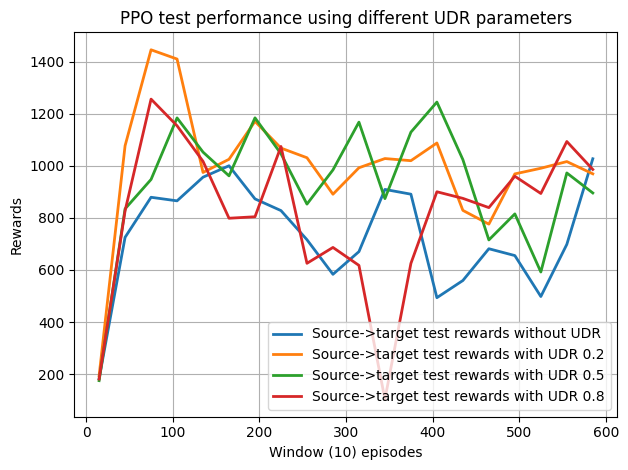

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def get_rewards (filename, window_size: int = 30):
    with open(filename, 'r') as f:
        lines = f.readlines()
        data = [float(line.strip()) for line in lines]

        means = []
        positions = []
        for i in range(0, len(data), window_size):
            window = data[i:i+window_size]
            mean_value = np.mean(window)
            means.append(mean_value)
            positions.append(i + window_size//2)
        
        return means, positions
    
path_test_resources = './trained-models/udr'

s_t_test_rewards, st_positions = get_rewards(f'{path_test_resources}/no-udr/test_rewards_CustomHopper-target-v0.txt')
plt.plot(st_positions[:20], s_t_test_rewards[:20], label=f'Source->target test rewards without UDR', linewidth=2)

deltas = [0.2, 0.5, 0.8]
for delta in deltas:
    r, p = get_rewards(f"{path_test_resources}/{delta}/test_rewards_CustomHopper-target-v0.txt")
    print(len(p))
    plt.plot(p[:20], r[:20], label=f'Source->target test rewards with UDR {delta}', linewidth=2)


plt.ylabel("Rewards")
plt.xlabel(f"Window ({10}) episodes")
plt.title("PPO test performance using different UDR parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()